In [9]:
from lbfgsb_scipy import LBFGSBScipy
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
from trace_expm import trace_expm
import numpy.linalg as la
import time

from concurrent.futures import ProcessPoolExecutor
from sklearn.preprocessing import StandardScaler

In [10]:
torch.set_default_dtype(torch.float64)

In [15]:
class NotearsRKHS(nn.Module):
    """n: number of samples, d: num variables"""
    def __init__(self, n, d, kernel):
        super(NotearsRKHS, self).__init__() # inherit  nn.Module
        self.d = d
        self.n = n
        self.kernel = kernel

        #torch.manual_seed(42)

        # initialize coefficients alpha
        self.fc1_pos = nn.Linear(n, d, bias=False)  # fc1_pos.weight = [d ,n], fc1_pos(x) = x @ fc1_pos.weight^T
        #self.fc1_neg = nn.Linear(n, d, bias=False)

        # Set positiv boundary for coefficients alpha to apply L-BFGS-B  
        # self.fc1_pos.weight.bounds = self._bounds() 
        # self.fc1_neg.weight.bounds = self._bounds()
        nn.init.zeros_(self.fc1_pos.weight)
        #nn.init.zeros_(self.fc1_neg.weight)
        self.I = torch.eye(self.d)

    # def _bounds(self):
    #     """Set boundary for coefficients alpha"""
    #     bounds = []
    #     for _ in range(self.n):
    #         for _ in range(self.d):
    #             bound = (0, None)
    #             bounds.append(bound)
    #     return bounds
    
    
    def get_fc1_weight(self): # [d, n]
       fc1_weight = self.fc1_pos.weight
       #print("fc1_weight shape: ", fc1_weight.shape)
       return fc1_weight
    
    #@timing_decorator
    @torch.no_grad()
    def gaussian_kernel_matrix_and_grad(self, x, gamma=1): # x: [n, d]; K: [n, n]; grad_K: [n, n, d]: gradient of k(x^i, x^l) wrt x^i_{k}
      #x = torch.tensor(x, requires_grad=True) 
      # Compute pairwise squared Euclidean distances using broadcasting
      diff = x.unsqueeze(1) - x.unsqueeze(0) # [n, n, d]
      sq_dist = torch.sum(diff ** 2, dim=2)

      # Compute the Gaussian kernel matrix
      K = torch.exp(-sq_dist / (gamma ** 2)) # [n, n]
      # Compute the gradient of K with respect to X
      grad_K = -2 * diff / (gamma ** 2) * K.unsqueeze(2) # K.unsqueeze(2): [n, n, 1]

      return K, grad_K
    
    #@timing_decorator
    @torch.no_grad()
    def matern3_2_kernel_matrix_and_grad(self, x, gamma=1): # K: [n, n]; grad_K: [n, n, d]: gradient of k(x^i, x^l) wrt x^i_{k}
       #x = torch.tensor(x, requires_grad=True)
       diff = x.unsqueeze(1) - x.unsqueeze(0) #[n, n, d]
       dist = torch.sqrt(torch.sum(diff ** 2, dim=2)) #[n, n]
       K = (1 + np.sqrt(3)*dist / gamma)*torch.exp(-np.sqrt(3)*dist / gamma) #[n, n]
       temp = -3/(gamma**2)*torch.exp(-np.sqrt(3)*dist/gamma) #[n, n]
       grad_K = diff*temp.unsqueeze(2)

       return K, grad_K
    
    #@timing_decorator
    @torch.no_grad()
    def matern5_2_kernel_matrix_and_grad(self, x, gamma=1): # [n, n, d]: gradient of k(x^i, x^l) wrt x^i_{k}
       #x = torch.tensor(x, requires_grad=True)
       diff = x.unsqueeze(1) - x.unsqueeze(0) #[n, n, d]
       dist = torch.sqrt(torch.sum(diff ** 2, dim=2)) #[n, n]
       K = (1 + np.sqrt(5)*dist / gamma + 5*(dist**2)/(3*(gamma**2)))*torch.exp(-np.sqrt(5)*dist / gamma)
       temp = (-5/(3*gamma**2) - 5*np.sqrt(5)*dist/(3*(gamma**3)))*torch.exp(-np.sqrt(5)*dist/gamma) #[n, n]
       grad_K = diff*temp.unsqueeze(2)

       return K, grad_K
    
    # @torch.no_grad()
    # def polynomial_kernel_matrix_and_grad(self, x, c=1, degree=3): # x: [n, d]; K: [n, n]; grad_K: [n, n, d]: gradient of k(x^i, x^l) wrt x^i_{k}
    #   #x = torch.tensor(x, requires_grad=True) 
    #   # Compute pairwise squared Euclidean distances using broadcasting
    #   mul = x.unsqueeze(1)*x.unsqueeze(0) # [n, n, d]

    #   # Compute the Gaussian kernel matrix
    #   K = (mul + c)**degree # [n, n]
    #   # Compute the gradient of K with respect to X
    #   grad_K = -2 * diff / (gamma ** 2) * K.unsqueeze(2) # K.unsqueeze(2): [n, n, 1]

    #   return K, grad_K
    
    #@timing_decorator
    def forward(self, x: torch.tensor): #[n,d] -> [n, d], forward(x)_{l,j} = estimation of x_j at lth observation 
      """
      x: data matrix of shape [n, d] (np.array)
      forward(x)_{l,j} = estimation of x_j at lth observation
      """
      if self.kernel == "gaussian":
        K = self.gaussian_kernel_matrix_and_grad(x)[0]
      elif self.kernel == "matern3_2":
        K = self.matern3_2_kernel_matrix_and_grad(x)[0]
      elif self.kernel == "matern5_2":
        K = self.matern5_2_kernel_matrix_and_grad(x)[0]
      else:
        print("Given kernel is invalid.")
        
      output = self.fc1_pos(K) #- self.fc1_neg(K)
      return output
    


    #@timing_decorator
    def fc1_to_adj(self, x: torch.tensor) -> torch.Tensor: # [d, d]
      if self.kernel == "gaussian":
        grad_K = self.gaussian_kernel_matrix_and_grad(x)[1] # [n, n, d]
      elif self.kernel == "matern3_2":
        grad_K = self.matern3_2_kernel_matrix_and_grad(x)[1]
      elif self.kernel == "matern5_2":
        grad_K = self.matern5_2_kernel_matrix_and_grad(x)[1]
      else:
        print("Given kernel is invalid.")

      fc1_weight = self.fc1_pos.weight #- self.fc1_neg.weight # [d, n]
      weight = torch.einsum('ji, lik -> jlk', fc1_weight, grad_K) # [d, n, d]
      weight = torch.sum(weight ** 2, dim = 1)/self.n # [d, d]
      return weight.t()
    
    #@timing_decorator
    # expoential h
    def h_func(self, x: torch.tensor):
      weight = self.fc1_to_adj(x)
      h = trace_expm(weight)-self.d
      return h
    
    # log determinant h
    # def h_func(self, x: torch.tensor, t = 200):
    #   weight = self.fc1_to_adj(x)
    #   #print("weight:", weight)
    #   A = t*self.I - weight
    #   sign, logabsdet = torch.linalg.slogdet(A)
    #   h = -logabsdet + self.d * np.log(t)
    #   #print("h: ", h)
    #   return h

    #spetrum h
    # def h_func(self, x: torch.tensor):
    #   weight = self.fc1_to_adj(x)
    #   w = torch.ones(self.d)
    #   for _ in range(10):
    #       w = weight @ w
    #       w = w / (torch.norm(w) + 1e-8)
    #   return w @ weight @ w
    

    #@timing_decorator
    def L_risk(self, x: torch.tensor, lambda1=0.0001): # [1, 1]
      """compute the regularized iempirical L_risk of squared loss function, penalty: penalty for H_norm"""
      if self.kernel == "gaussian":
          K = self.gaussian_kernel_matrix_and_grad(x)[0] # [n, n]
      elif self.kernel == "matern3_2":
          K = self.matern3_2_kernel_matrix_and_grad(x)[0] # [n, n]
      elif self.kernel == "matern5_2":
          K = self.matern5_2_kernel_matrix_and_grad(x)[0] # [n, n]
      else:
          print("Given kernel is invalid.") 

      x_est = self.forward(x) # [n, d]
      squared_loss = 0.5 / self.n * torch.sum((x_est - x) ** 2)
      fc1_weight = self.fc1_pos.weight #- self.fc1_neg.weight
      temp = torch.matmul(torch.matmul(fc1_weight, K), fc1_weight.t())
      diagonal = torch.sum(torch.diag(temp))
      regularized = lambda1*diagonal 
      loss = squared_loss + regularized
      return loss
  
    
  

In [16]:
def learning(model, X):
    rho, mu, h = 1000000000.0, 0.0, np.inf
    x_torch = torch.from_numpy(X)
    h_new = None
    optimizer = LBFGSBScipy(model.parameters())

    def closure():
            optimizer.zero_grad()
            h_val = model.h_func(x_torch)
            print("h_val: ", h_val)
            #penalty = 0.5 * rho * h_val * h_val + mu * h_val
            L_risk = model.L_risk(x_torch)
            loss = L_risk #+ penalty
            print('L_risk:', L_risk.item())
            print('loss:', loss.item())
            loss.backward()
            return loss
        
        #start_time = time.time()
    optimizer.step(closure)
    h_new = model.h_func(x_torch).item()
    print("h_new: ", h_new)

    output = model.forward(x_torch)
    W_est = model.fc1_to_adj(x_torch)
    W_est = torch.sqrt(W_est)
    W_est = W_est.detach().numpy()
    print(W_est)
    return output

In [99]:
def dual_ascent_step(model, X, lambda1, rho, mu, h, rho_max):
    """Perform one step of dual ascent in augmented Lagrangian."""
    h_new = None
    optimizer = LBFGSBScipy(model.parameters())
    X_torch = torch.from_numpy(X)
    while rho < rho_max:
        print("rho: ", rho)
        def closure():
            optimizer.zero_grad()
            L_risk = model.L_risk(X_torch, lambda1=lambda1)
            h_val = model.h_func(X_torch)
            print("h_val: ", h_val)
            penalty = 0.5 * rho * h_val * h_val + mu * h_val
            primal_obj = L_risk + penalty
            primal_obj.backward()
            print('L_risk:', L_risk.item())
            print('loss:', primal_obj.item())
            #print('penalty:', penalty.item())
            return primal_obj
        optimizer.step(closure)  # NOTE: updates model in-place
        with torch.no_grad():
            h_new = model.h_func(X_torch).item()
            print("h_new: ", h_new)
        if h_new > 0.25 * h:
            rho *= 10
        else:
            break
    mu += rho * h_new
    return rho, mu, h_new


def notears_nonlinear(model: nn.Module,
                      X: np.ndarray,
                      lambda1: float = 0.0001,
                      max_iter: int = 100,
                      h_tol: float = 1e-8,
                      rho_max: float = 1e+16,
                      w_threshold: float = 0.3):
    rho, mu, h = 1.0, 1.0, np.inf
    for k in range(max_iter):
        rho, mu, h = dual_ascent_step(model, X, lambda1,
                                         rho, mu, h, rho_max)
        print("iteration: ", k+1)
        if h <= h_tol or rho >= rho_max:
            break
    X_torch = torch.tensor(X, dtype=torch.float64, requires_grad=True)
    W_est = model.fc1_to_adj(X_torch)
    W_est = torch.sqrt(W_est)
    W_est = W_est.detach().numpy()
    print(W_est)
    W_est[np.abs(W_est) < w_threshold] = 0
    W_est[np.abs(W_est) >= w_threshold] = 1
    output = model.forward(X_torch)
    return W_est, output

In [17]:
np.random.seed(2)
x = np.random.normal(10,2, 100)

np.random.seed(24)
l = np.random.normal(0,1, 100) 

# marker
np.random.seed(25)
b = np.random.normal(0,1, 100) 


y = [x**2 + l for x, l in zip(x, l)]

X = np.column_stack((x, y))

n = X.shape[0]
d = X.shape[1]

print(n)
print(d)

model = NotearsRKHS(n, d, "gaussian")
#W_est, output = notears_nonlinear(model, X)
output = learning(model, X)

100
2
h_val:  tensor(0., grad_fn=<SubBackward0>)
L_risk: 5889.293525997783
loss: 5889.293525997783
h_val:  tensor(0.0155, grad_fn=<SubBackward0>)
L_risk: 5865.199892148727
loss: 5865.199892148727
h_val:  tensor(0.4675, grad_fn=<SubBackward0>)
L_risk: 5769.74267545799
loss: 5769.74267545799
h_val:  tensor(866.6801, grad_fn=<SubBackward0>)
L_risk: 5402.59090798289
loss: 5402.59090798289
h_val:  tensor(1.3797e+48, grad_fn=<SubBackward0>)
L_risk: 4168.817426687971
loss: 4168.817426687971
h_val:  tensor(inf, grad_fn=<SubBackward0>)
L_risk: 1674.263350495443
loss: 1674.263350495443
h_val:  tensor(inf, grad_fn=<SubBackward0>)
L_risk: 965.5109618155076
loss: 965.5109618155076
h_val:  tensor(inf, grad_fn=<SubBackward0>)
L_risk: 280.7121250440017
loss: 280.7121250440017
h_val:  tensor(inf, grad_fn=<SubBackward0>)
L_risk: 404.9409878944685
loss: 404.9409878944685
h_val:  tensor(inf, grad_fn=<SubBackward0>)
L_risk: 173.3946017907823
loss: 173.3946017907823
h_val:  tensor(inf, grad_fn=<SubBackward0

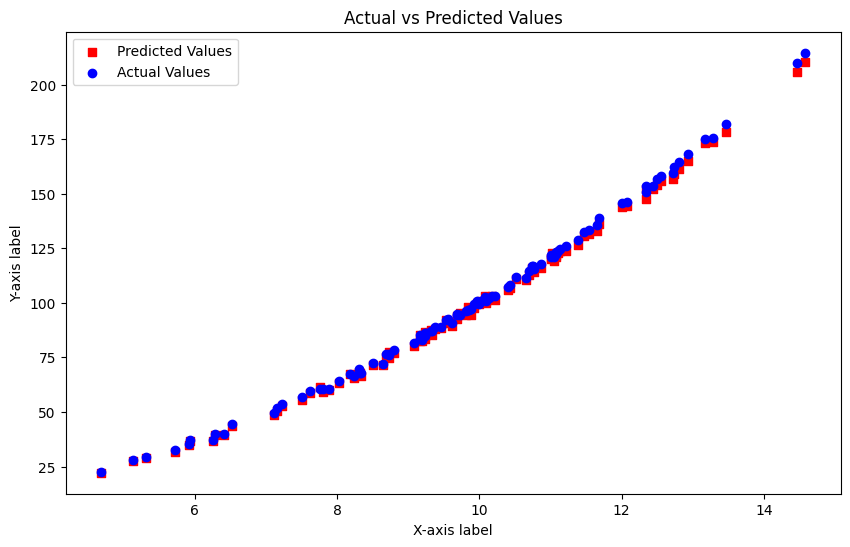

In [18]:
y = np.array(y)
y_hat = output[:, 1].detach().numpy()

plt.figure(figsize=(10, 6))  # Optional: specifies the figure size


# Plot predicted values
plt.scatter(x, y_hat, label='Predicted Values', color='red', marker='s')  # Plot x vs. y_hat

# Plot actual values
plt.scatter(x, y, label='Actual Values', color='blue', marker='o')  # Plot x vs. y

plt.legend()  # Show legend to differentiate between actual and predicted values
plt.title('Actual vs Predicted Values')  # Optional: Adds a title to the plot
plt.xlabel('X-axis label')  # Optional: Label for the x-axis
plt.ylabel('Y-axis label')  # Optional: Label for the y-axis
plt.show()

In [19]:
np.random.seed(2)
x = np.random.normal(0, 1, 100) 
#x = np.clip(x, -1.5, 1.5)

np.random.seed(24)
l = np.random.normal(0, 0.01, 100) 


y = [np.sin(x) + l for x, l in zip(x, l)]
#z = [np.log(np.abs(x)) + b for x, b in zip(x, b)]

X = np.column_stack((x, y))
n = X.shape[0]
d = X.shape[1]

print(n)
print(d)

model = NotearsRKHS(n, d, "gaussian")
output = learning(model, X)

100
2
h_val:  tensor(0., grad_fn=<SubBackward0>)
L_risk: 0.7508787428908255
loss: 0.7508787428908255
h_val:  tensor(38.0748, grad_fn=<SubBackward0>)
L_risk: 0.9999191573739542
loss: 0.9999191573739542
h_val:  tensor(1.1240, grad_fn=<SubBackward0>)
L_risk: 0.21299428599063952
loss: 0.21299428599063952
h_val:  tensor(1.0670, grad_fn=<SubBackward0>)
L_risk: 0.17851682260466112
loss: 0.17851682260466112
h_val:  tensor(0.9699, grad_fn=<SubBackward0>)
L_risk: 0.13902772882069775
loss: 0.13902772882069775
h_val:  tensor(1.3087, grad_fn=<SubBackward0>)
L_risk: 0.04913937383266307
loss: 0.04913937383266307
h_val:  tensor(1.3396, grad_fn=<SubBackward0>)
L_risk: 0.045638578058927036
loss: 0.045638578058927036
h_val:  tensor(1.3367, grad_fn=<SubBackward0>)
L_risk: 0.03981456627639504
loss: 0.03981456627639504
h_val:  tensor(1.2937, grad_fn=<SubBackward0>)
L_risk: 0.030493832410050183
loss: 0.030493832410050183
h_val:  tensor(1.2858, grad_fn=<SubBackward0>)
L_risk: 0.01835669070431346
loss: 0.01835

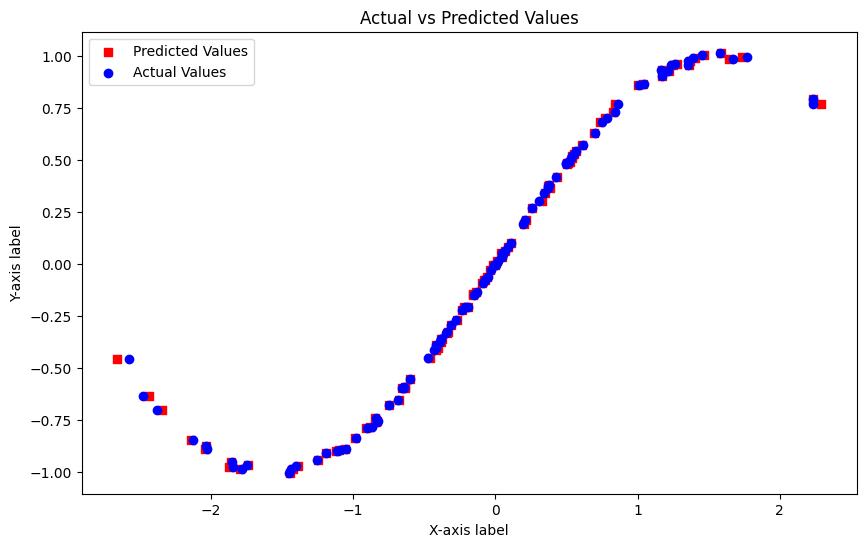

In [20]:
x = np.array(x)
x_hat = output[:, 0].detach().numpy()

plt.figure(figsize=(10, 6))  # Optional: specifies the figure size


# Plot predicted values
plt.scatter(x, y, label='Predicted Values', color='red', marker='s')  # Plot x vs. y_hat

# Plot actual values
plt.scatter(x_hat, y, label='Actual Values', color='blue', marker='o')  # Plot x vs. y

plt.legend()  # Show legend to differentiate between actual and predicted values
plt.title('Actual vs Predicted Values')  # Optional: Adds a title to the plot
plt.xlabel('X-axis label')  # Optional: Label for the x-axis
plt.ylabel('Y-axis label')  # Optional: Label for the y-axis
plt.show()

h_val:  tensor(0., grad_fn=<SubBackward0>)
L_risk: 23.660786211446553
loss: 23.660786211446553
h_val:  tensor(0.0506, grad_fn=<SubBackward0>)
L_risk: 20.670070344408717
loss: 20.670070344408717
h_val:  tensor(8.0254, grad_fn=<SubBackward0>)
L_risk: 4.289068977586932
loss: 4.289068977586932
h_val:  tensor(14.2022, grad_fn=<SubBackward0>)
L_risk: 2.6536057295833113
loss: 2.6536057295833113
h_val:  tensor(8.2513, grad_fn=<SubBackward0>)
L_risk: 1.071245924228759
loss: 1.071245924228759
h_val:  tensor(7.3832, grad_fn=<SubBackward0>)
L_risk: 0.8260319039509655
loss: 0.8260319039509655
h_val:  tensor(7.4425, grad_fn=<SubBackward0>)
L_risk: 0.6751066902340511
loss: 0.6751066902340511
h_val:  tensor(7.9027, grad_fn=<SubBackward0>)
L_risk: 0.5358229988749932
loss: 0.5358229988749932
h_val:  tensor(7.8754, grad_fn=<SubBackward0>)
L_risk: 0.4364262919648422
loss: 0.4364262919648422
h_val:  tensor(8.2584, grad_fn=<SubBackward0>)
L_risk: 0.3915303908796848
loss: 0.3915303908796848
h_val:  tensor(7.

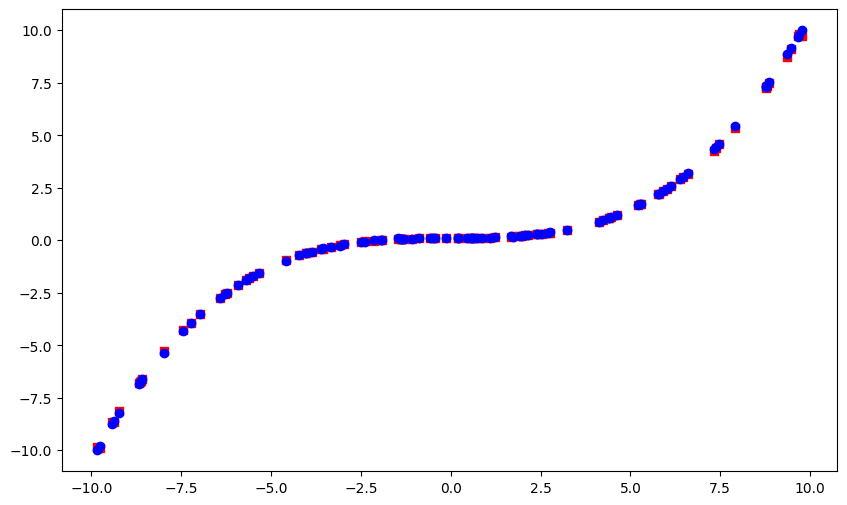

In [21]:
np.random.seed(8)
x = np.random.uniform(low=-10, high=10, size=100)

b = np.random.normal(0,1, 100) 



y = [x**3 + x + b for x, b in zip(x, b)]

y = np.array(y)  # your y data here

# Step 1: Determine the current range of y
y_min, y_max = y.min(), y.max()

# Step 2: No explicit step needed here, as we use the formula directly in step 3

# Step 3: Apply the scaling transformation
y_scaled = ((y - y_min) * (10 - (-10))) / (y_max - y_min) + (-10)

X = np.column_stack((x, y_scaled))

n = X.shape[0]
d = X.shape[1]


model = NotearsRKHS(n, d, "gaussian")
output = learning(model, X)

y_hat = output[:, 1].detach().numpy()
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(x, y_hat, label='y2', color='red', marker='s') 
plt.scatter(x, y_scaled, label='y1', color='blue', marker='o')  # Plot x vs. y1